## Chapter 2-4, 1강 Computer Vision MLP & CNN(PyTorch, CPU): CIFAR-10 분류 
- 데이터 다운로드 -> 데이터 탐색 → MLP vs CNN → 내부 시각화 → 오분류 분석 → 개선



### 0. 환경 설정 및 라이브러리

In [1]:
# 필요한 라이브러리 임포트
import os, time, random, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix, classification_report
import itertools

# GPU 사용 가능 여부 확인 (CUDA가 있으면 GPU, 없으면 CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

# 시드 고정 함수 (재현성 확보를 위해 랜덤성 통제)
def set_seed(seed=42):
    random.seed(seed)                   # 파이썬 기본 random 시드 고정
    np.random.seed(seed)                # 넘파이 시드 고정
    torch.manual_seed(seed)             # 파이토치 시드 고정 (CPU 연산용)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed) # GPU 연산 시 여러 GPU에 동일 시드 적용
set_seed(42)

import matplotlib.pyplot as plt
from matplotlib import rc

# 한글 글꼴 설정
plt.rcParams['font.family'] = 'AppleGothic'  # Mac의 기본 한글 글꼴
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지


Device: cpu


In [2]:
# -------------------------------
# 역정규화(denormalization) 유틸리티 함수
# CIFAR-10 데이터셋의 평균과 표준편차 값을 사용
# 학습 시 normalize했던 이미지를 다시 원래 색감으로 되돌리는 용도
# -------------------------------
inv_mean = np.array([0.4914, 0.4822, 0.4465])  # CIFAR-10 채널별 평균
inv_std  = np.array([0.2470, 0.2435, 0.2616])  # CIFAR-10 채널별 표준편차

def denorm(img_tensor):
    """
    정규화된 이미지를 다시 원래 픽셀값(0~1) 범위로 변환하는 함수

    Args:
        img_tensor (torch.Tensor): (C,H,W) 형태의 이미지 텐서
    
     - C (Channels): 채널 수
        . RGB 이미지의 경우: 3 (Red, Green, Blue)
        . RGBA 이미지의 경우: 4 (Red, Green, Blue, Alpha)
        . H (Height): 이미지의 높이 (세로 픽셀 수)
        . W (Width): 이미지의 너비 (가로 픽셀 수)
        . 예를 들어:
            (3, 224, 224): RGB 이미지, 224x224 픽셀
            (1, 28, 28): 그레이스케일 이미지, 28x28 픽셀 (MNIST 같은 경우)
            (4, 512, 512): RGBA 이미지, 512x512 픽셀

    Returns:
        numpy.ndarray: (H,W,C) 형태의 이미지, 픽셀 범위 0~1
    """
    # 텐서를 (H, W, C) 순서로 변환 후 numpy 배열로 변경
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    # 정규화 해제: (이미지 * 표준편차) + 평균
    img = img * inv_std + inv_mean
    # 0~1 범위로 잘라내기
    return np.clip(img, 0, 1)


### 1. 데이터 다운로드 및 DataLoader 설정

In [3]:
# -------------------------------
# 전처리: 정규화 (Normalization)
# CIFAR-10 데이터셋의 채널별 평균과 표준편차를 사용하여
# 입력 이미지를 평균 0, 표준편차 1에 가깝게 맞춰줌
# -------------------------------
train_tf = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환 (0~255 → 0~1 범위), 차원 순서를 (H, W, C)에서 (C, H, W)로 변경
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),  # 채널별 평균 (R,G,B)
        (0.2470, 0.2435, 0.2616)   # 채널별 표준편차 (R,G,B)
    )
])
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2470, 0.2435, 0.2616)
    )
])


In [4]:
# -------------------------------
# 데이터셋 다운로드 및 로드
# root 폴더에 CIFAR-10 데이터셋이 없으면 자동 다운로드
# -------------------------------
root = './data'
train_full = datasets.CIFAR10(
    root=root, train=True, download=True, transform=train_tf #정규화만 실행
)  # 전체 학습용(train=True) 데이터셋
test_set = datasets.CIFAR10(
    root=root, train=False, download=True, transform=test_tf #정규화만 실행
)  # 테스트용(train=False) 데이터셋

# CIFAR-10 클래스 이름 (10개 클래스: airplane, car, bird, cat ...)
class_names = train_full.classes

# -------------------------------
# 학습 데이터 → 학습(train) / 검증(validation) 데이터로 분리
# -------------------------------
val_ratio = 0.2                           # 전체 학습 데이터 중 20%를 검증용으로 사용
val_len   = int(len(train_full) * val_ratio)  # 검증 데이터 개수
train_len = len(train_full) - val_len         # 학습 데이터 개수

# 랜덤하게 split (train/val 구분)
train_set, val_set = random_split(
    train_full, [train_len, val_len]
)


In [5]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
# -------------------------------
# DataLoader 생성
# 학습 시 배치 단위로 데이터를 불러오고,
# shuffle 여부 및 멀티프로세싱(num_workers) 지정 가능
# -------------------------------
train_loader = DataLoader(
    train_set, batch_size=128, shuffle=True, num_workers=0
)  # 학습용 (데이터 무작위 섞음)
val_loader = DataLoader(
    val_set, batch_size=128, shuffle=False, num_workers=0
)    # 검증용 (섞지 않음)
test_loader = DataLoader(
    test_set, batch_size=128, shuffle=False, num_workers=0
)   # 테스트용 (섞지 않음)

# -------------------------------
# 데이터셋 크기 및 샘플 이미지 형태 출력
# -------------------------------
print('Train/Val/Test sizes:', len(train_set), len(val_set), len(test_set))
# 학습용, 검증용 테스트용 데이터셋의 크기를 출력하는 것으로
# Train/Val/Test sizes: 40000 10000 10000이라고 출력됨
print('Sample image shape (C,H,W):', train_set[0][0].shape)
# 샘플 이미지의 텐서 크기를 출력하는 것으로
# torch.Size([3, 32, 32])라고 출력되는데 
# 채널은 RGB(3갸)이며 이미지 크기는 32픽셀 × 32픽셀이라는 의미


Train/Val/Test sizes: 40000 10000 10000
Sample image shape (C,H,W): torch.Size([3, 32, 32])


### 2. 데이터 탐색

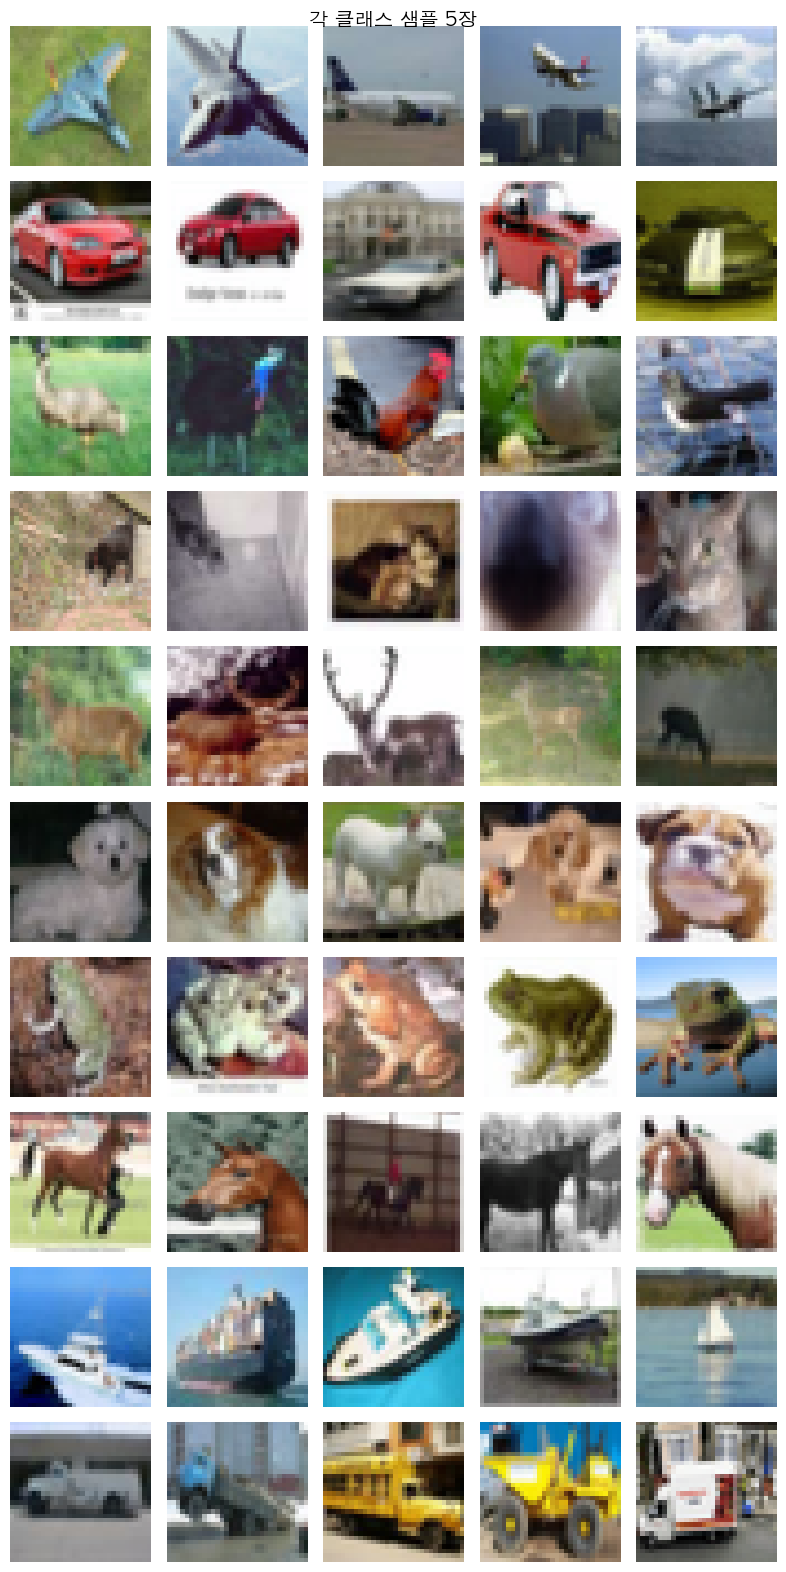

In [7]:
# CIFAR-10 클래스별 샘플 5장씩 시각화
import math
fig, axes = plt.subplots(10, 5, figsize=(8,16))  # 10행(클래스), 5열(샘플) 서브플롯 생성
counts = {c:0 for c in class_names}              # 각 클래스별로 몇 장을 그렸는지 카운트

# train_loader에서 배치 단위로 이미지와 라벨 가져오기
for x, y in train_loader:
    # 배치 내 이미지(img)와 라벨(lab) 순회
    for img, lab in zip(x, y):
        c = class_names[lab.item()]  # 정수 라벨 → 클래스 이름으로 변환
        # 해당 클래스에서 아직 5장을 다 못 그렸을 경우에만 처리
        if counts[c] < 5:
            # 클래스 인덱스(row), 현재까지 그린 장 수(col)로 위치 결정
            ax = axes[class_names.index(c), counts[c]]
            # 정규화 해제 후 이미지 출력
            ax.imshow(denorm(img))
            ax.set_axis_off()  # x, y 축 제거
            # 각 클래스 첫 번째 열에는 클래스 이름을 y축 레이블로 표시
            if counts[c] == 0:
                ax.set_ylabel(c, rotation=0, labelpad=30, va='center')
            counts[c] += 1  # 카운트 증가
    # 모든 클래스에서 5장씩 다 모으면 반복 종료
    if all(counts[c] >= 5 for c in class_names):
        break

# 전체 제목 + 레이아웃 정리 + 시각화
plt.suptitle('각 클래스 샘플 5장', fontsize=14)
plt.tight_layout()
plt.show()


#### CIFAR-10의 해상도 특징
- 크기: 32 × 32 픽셀
- 채널: RGB (3채널)
- 데이터 수: 60,000장 (train 50,000 + test 10,000)
- 클래스 수: 10개 (비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭)
- 한 이미지가 겨우 32 × 32 픽셀이라 사람 눈에는 뭉개진 저해상도 사진처럼 보이는 게 정상입니다.

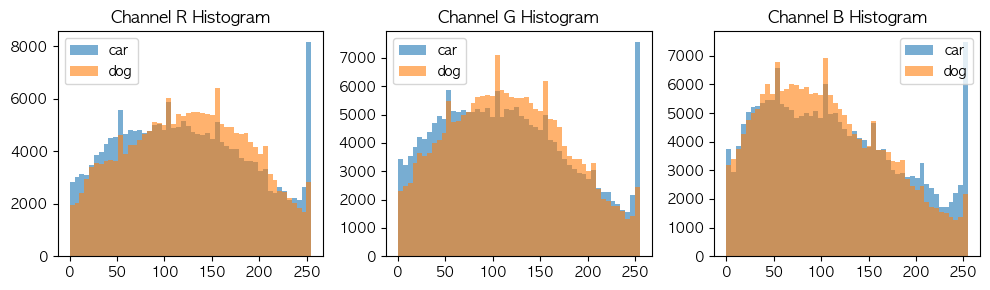

cars array: (200, 32, 32, 3) dogs array: (200, 32, 32, 3)


In [8]:
# 자동차 vs 개 RGB 채널별 히스토그램 비교
from torchvision.datasets import CIFAR10

# -------------------------------
# raw_train: 정규화/텐서 변환 전, 원본 PIL 이미지 접근용 CIFAR-10 데이터셋
# (ToTensor, Normalize 같은 transform을 적용하지 않고 원본 픽셀값을 보려는 용도)
# -------------------------------
# CIFAR-10 원본 학습 데이터셋 불러오기 (PIL 이미지 형태)
raw_train = CIFAR10(
    root='./data',       # 데이터 저장/불러올 경로
    train=True,          # 학습용 데이터셋 (True), 테스트셋은 False
    download=False       # 데이터 없으면 다운로드 여부 (False면 로컬에 있어야 함)
)

# 특정 클래스(label_name)의 이미지를 모아서 Numpy 배열로 반환하는 함수
def collect_pixels(label_name, max_imgs=200):
    idx_label = class_names.index(label_name)  # 클래스 이름 → 정수 라벨 인덱스
    vals = []   # 이미지를 담을 리스트
    cnt = 0
    for img, lab in raw_train:   # 원본 학습 데이터셋 순회
        if lab == idx_label:     # 해당 라벨의 이미지일 경우
            vals.append(np.array(img))  # PIL.Image → numpy array (H,W,3), 값 범위 0~255
            cnt += 1
            if cnt >= max_imgs:  # max_imgs 개수만큼 모았으면 종료
                break
    # (N, H, W, 3) 형태의 배열로 합치기 (N = 이미지 개수)
    arr = np.stack(vals, axis=0)
    return arr

# 자동차(automobile) 이미지 200장 수집
cars = collect_pixels('automobile', max_imgs=200)
# 개(dog) 이미지 200장 수집
dogs = collect_pixels('dog', max_imgs=200)

# -------------------------------
# RGB 채널별 히스토그램 비교 시각화
# -------------------------------
plt.figure(figsize=(10,3))
for i, ch in enumerate(['R','G','B']):
    plt.subplot(1,3,i+1)
    # 자동차 이미지의 i번째 채널 픽셀 히스토그램
    plt.hist(cars[:,:,:,i].ravel(), bins=50, alpha=0.6, label='car')
    # 개 이미지의 i번째 채널 픽셀 히스토그램
    plt.hist(dogs[:,:,:,i].ravel(), bins=50, alpha=0.6, label='dog')
    plt.title(f'Channel {ch} Histogram')
    plt.legend()

plt.tight_layout()
plt.show()

# -------------------------------
# 배열 크기 출력: (N,H,W,C)
# 자동차 200장, 개 200장 이미지 수집 결과
# -------------------------------
print('cars array:', cars.shape, 'dogs array:', dogs.shape)


##### 자동차(car) vs 개(dog) RGB 채널별 히스토그램 해석
- X축: 픽셀 값 (0~255)
- Y축: 해당 값의 픽셀 개수 (빈도수)
- 색상: 파란색(car), 주황색(dog)

##### 1) R 채널 (왼쪽)
- 자동차: 낮은 값(0~100) 쪽에 분포 많음 → 차체 색/배경 영향
- 개: 중간~높은 값(100~200) 분포 두드러짐 → 갈색/붉은색 털 때문
##### 2) G 채널 (가운데)
- 자동차: 분포가 넓고 높은 값(200 근처)도 많음 → 하늘/도로 배경 영향
- 개: 중간 영역(100~150) 집중 → 털 색깔 영향
##### 3) B 채널 (오른쪽)
- 자동차: 낮은 값(0~100) + 높은 값(200 이상) 피크 → 배경 하늘 영향
- 개: 중간 값에 고르게 분포 → 갈색 털 특성 (파랑 성분 약함)
##### 4) 결론:
- 자동차는 파랑(B) 성분이 강하고, 개는 R/G 성분이 더 두드러짐



### 3. Baseline 비교 (MLP vs CNN)

- MLP(Multi-Layer Perceptron)는 공간 정보를 활용하지 못함 → 파라미터 수 대비 비효율적.  
- CNN은 지역(커널) 단위로 가중치를 공유 → 효율성↑, 일반화↑.

**질문:** “같은 파라미터 수라면 어떤 구조가 더 유리할까요?”


In [9]:
# -------------------------------
# 다층 퍼셉트론 (MLP:Multi-Layer Perceptron) 모델 정의
# CIFAR-10 입력(32x32x3)을 일렬로 펼쳐서 전결합층으로 분류
# -------------------------------
class MLP(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()  # (C,H,W) → (C*H*W)로 평탄화
        self.fc = nn.Sequential(
            nn.Linear(32*32*3, 256),  # 입력: 3072 → 은닉층 256
            nn.ReLU(),                # 활성화 함수
            nn.Dropout(0.3),          # 과적합 방지 dropout
            nn.Linear(256, num_classes)  # 출력: 클래스 수(10)
        )
    def forward(self, x):
        # (N,3,32,32) → flatten → (N,3072) → fc → (N,10)
        return self.fc(self.flatten(x))

In [11]:
# -------------------------------
# 간단한 CNN (Convolutional Neural Network) 모델 정의
# 이미지의 공간적 특성을 고려하여 합성곱 + 풀링을 적용
# -------------------------------
class CNN_V1(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # 특징 추출부 (convolution + pooling)
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),   # 입력: RGB(3) → 32채널
            nn.MaxPool2d(2),                            # 크기 절반 (32→16)
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), # 32채널 → 64채널
            nn.MaxPool2d(2),                            # 크기 절반 (16→8)
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU() # 64채널 → 128채널
        )
        # 분류기 (classifier)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),   # 출력 크기를 (1,1)로 고정 → GAP(Global Avg Pooling) 효과, 공간 정보를 제거하고 채널별 특징만 남겨서 최종 분류에 사용
            nn.Flatten(),                  # (N,128,1,1) → (N,128)
            nn.Dropout(0.3),               # dropout 적용
            nn.Linear(128, num_classes)    # 128 → 클래스 수(10)
        )
    def forward(self, x):
        # 입력 이미지 → 특징 추출(features) → 분류(classifier)
        return self.classifier(self.features(x))

In [12]:
# -------------------------------
# 파라미터 수 계산 함수
# -------------------------------
def count_params(model):
    # requires_grad=True인 학습 대상 파라미터들의 총 개수를 합산
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 모델 인스턴스 생성 및 디바이스 할당 (CPU/GPU)
mlp = MLP().to(device)
cnn = CNN_V1().to(device)

# 각 모델의 학습 가능한 파라미터 수 출력
print('MLP params:', count_params(mlp))
print('CNN_V1 params:', count_params(cnn))


MLP params: 789258
CNN_V1 params: 94538


In [13]:
# -------------------------------
# CNN_V1의 각 레이어별 출력 텐서 크기 출력
# -------------------------------
shapes = []  # 각 레이어의 출력 텐서 크기를 순서대로 기록할 리스트

model = CNN_V1()  # 모델 인스턴스 생성

def make_hook(name):
    # forward_hook 팩토리: 레이어 이름과 출력 텐서의 shape를 기록하는 훅을 생성
    def _hook(module, inp, out):
        shapes.append((name, out.shape))  # (레이어이름, 출력크기) 저장
    return _hook

hooks = []  # 등록된 hook 핸들을 보관(나중에 해제용)
for i, layer in enumerate(list(model.features) + list(model.classifier)):
    name = f"{layer.__class__.__name__}_{i}"  # 같은 클래스명이라도 인덱스로 고유하게
    hooks.append(layer.register_forward_hook(make_hook(name)))  # 훅 등록

out = model(x)  # 순전파 실행 → 각 레이어에서 훅이 호출되어 shapes가 채워짐

for h in hooks:
    h.remove()  # 사용이 끝난 훅 해제(메모리/중복 호출 방지)

for name, shape in shapes:
    print(f"{name:20s} -> {shape}")  # 레이어 이름과 출력 텐서 크기 출력

Conv2d_0             -> torch.Size([128, 32, 32, 32])
ReLU_1               -> torch.Size([128, 32, 32, 32])
MaxPool2d_2          -> torch.Size([128, 32, 16, 16])
Conv2d_3             -> torch.Size([128, 64, 16, 16])
ReLU_4               -> torch.Size([128, 64, 16, 16])
MaxPool2d_5          -> torch.Size([128, 64, 8, 8])
Conv2d_6             -> torch.Size([128, 128, 8, 8])
ReLU_7               -> torch.Size([128, 128, 8, 8])
AdaptiveAvgPool2d_8  -> torch.Size([128, 128, 1, 1])
Flatten_9            -> torch.Size([128, 128])
Dropout_10           -> torch.Size([128, 128])
Linear_11            -> torch.Size([128, 10])


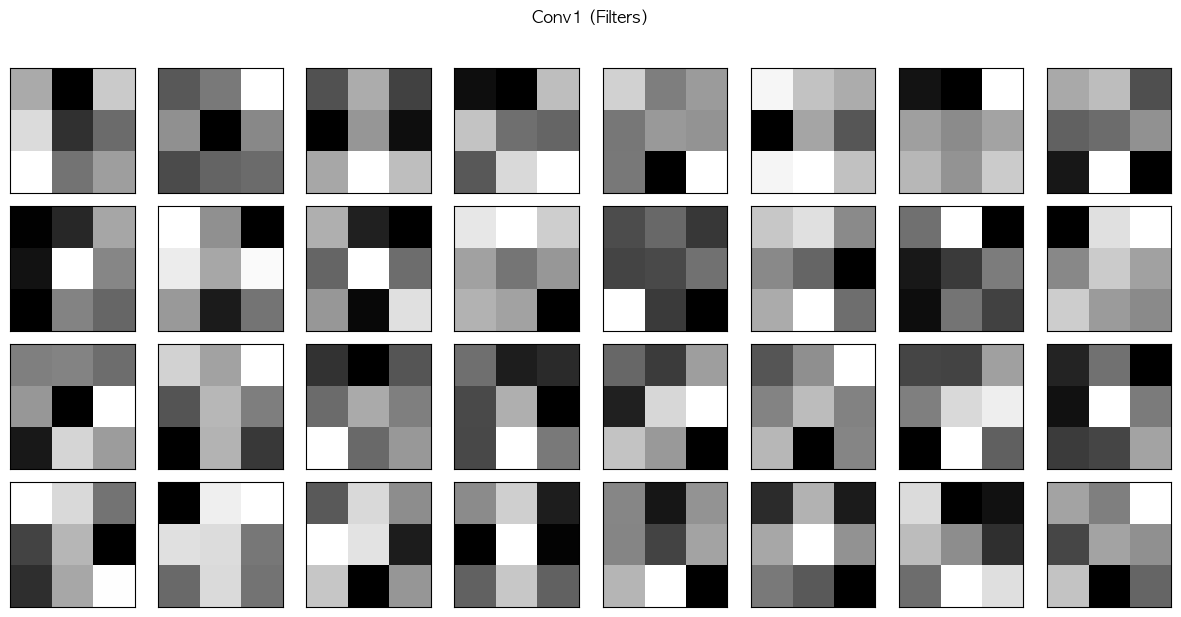

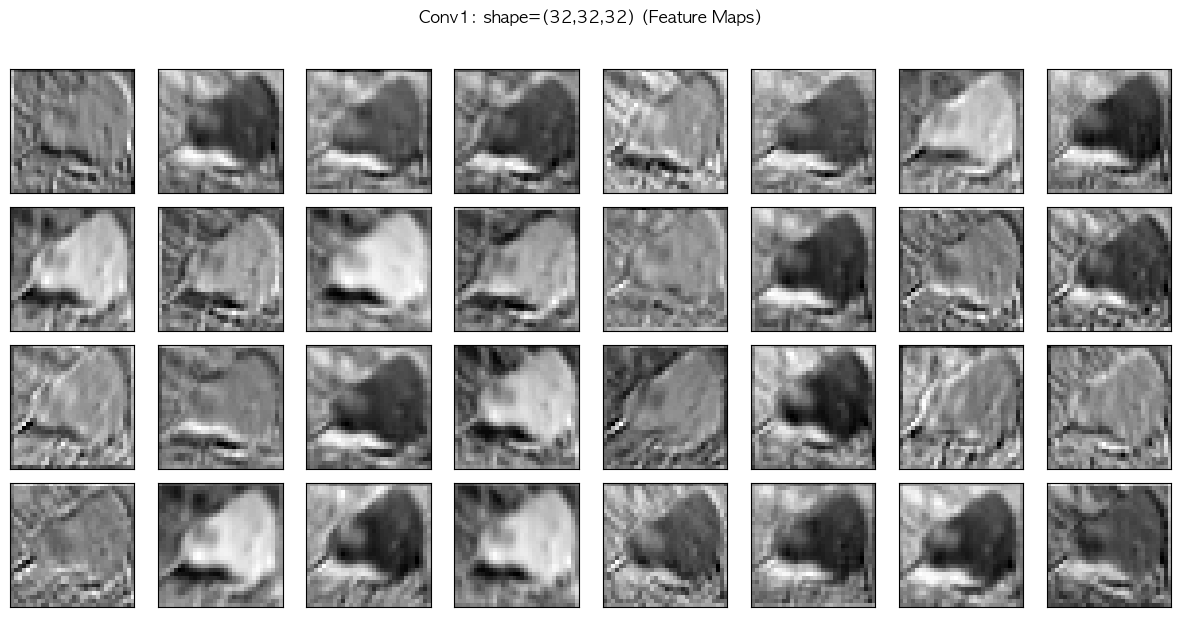

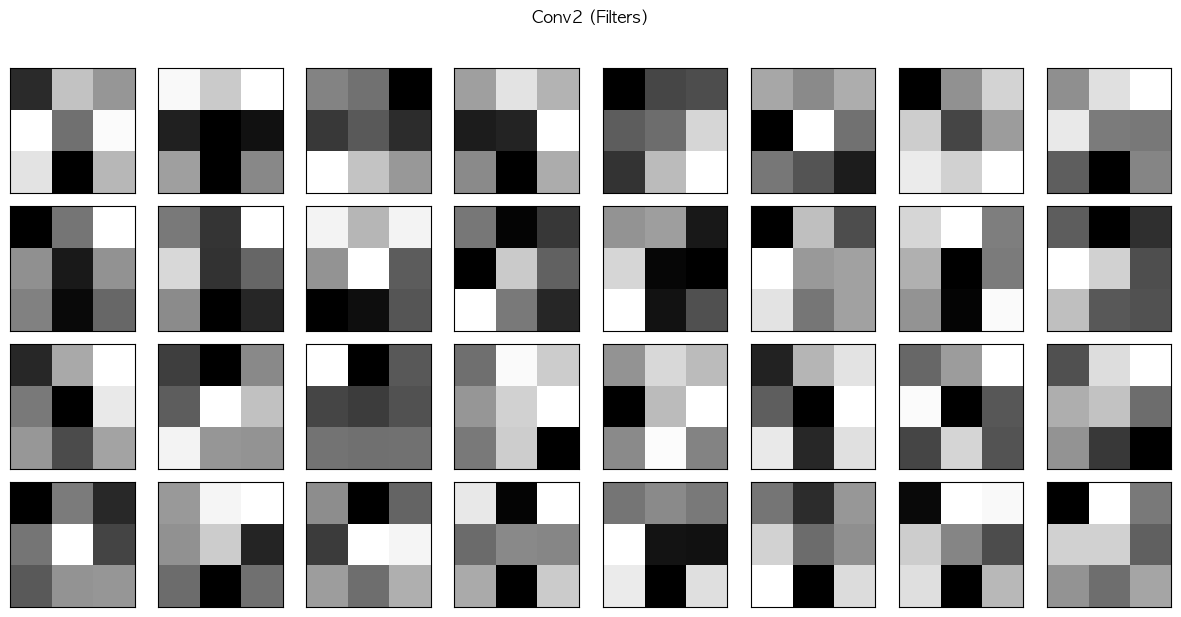

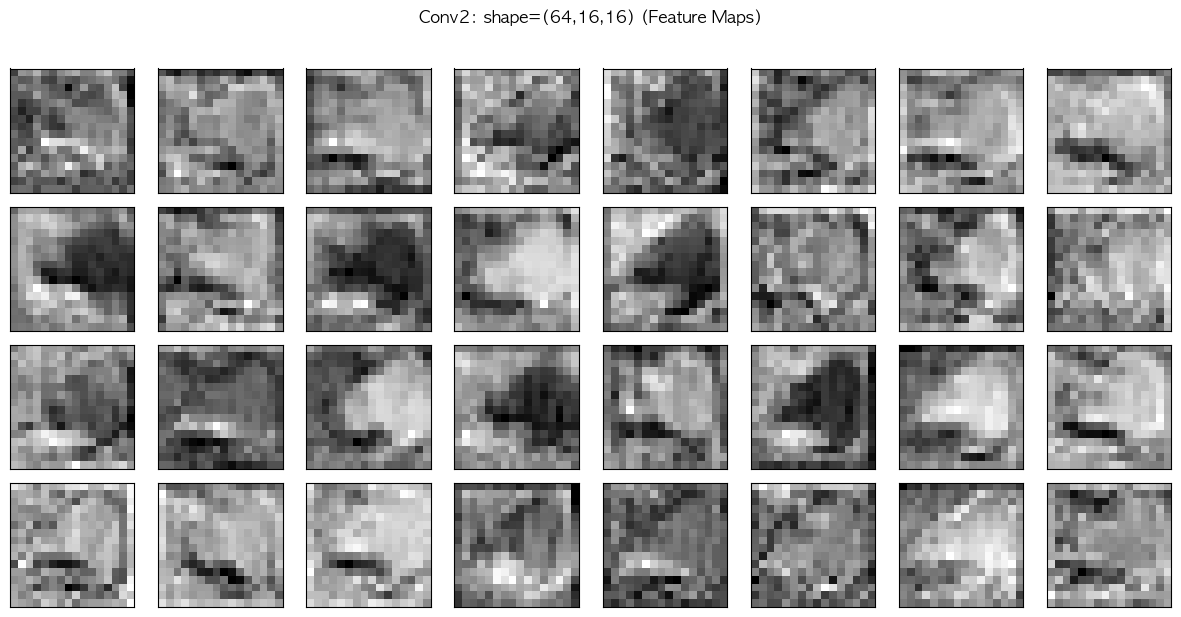

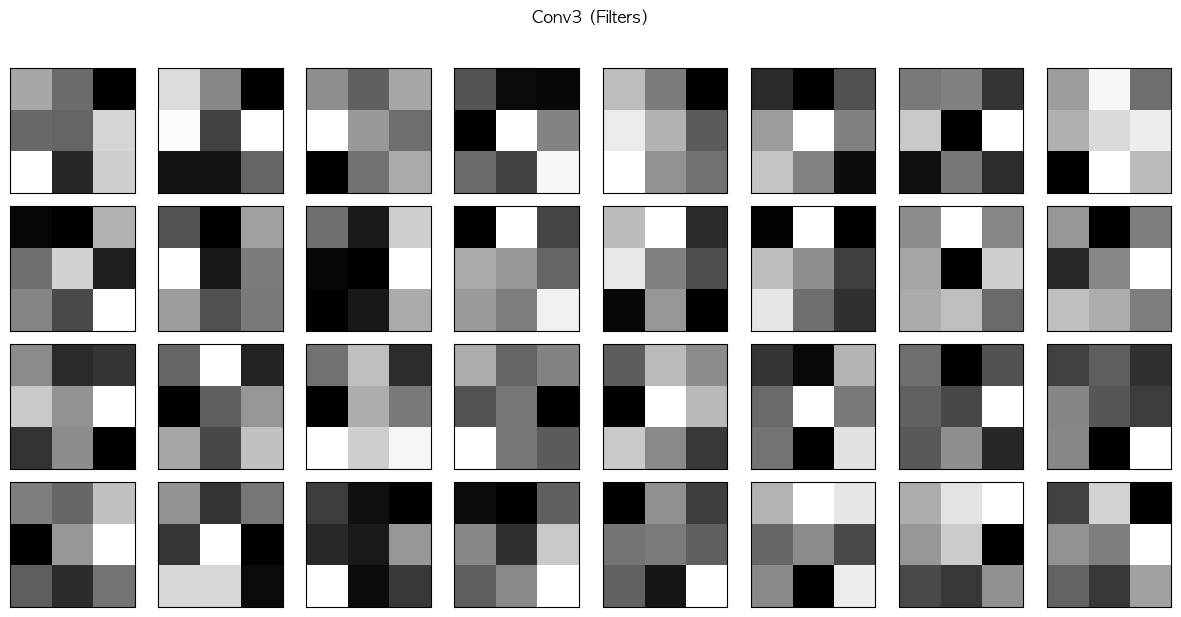

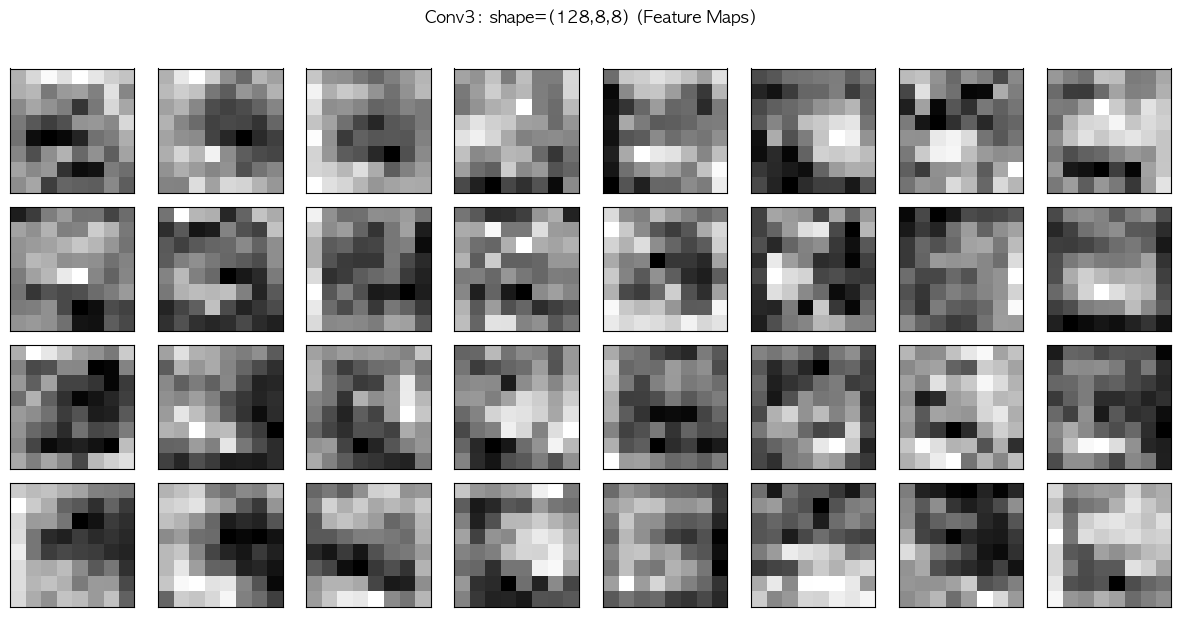

In [14]:
# =========================================================
# CNN_V1의 Conv 레이어별
# 1) 필터(커널 가중치)
# 2) 해당 필터로 나온 feature map
# 을 나란히 시각화
# =========================================================
import math
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

# activations 저장용 딕셔너리
activations = {}

def save_activation(name):
    def hook(m, i, o):
        activations[name] = o.detach().cpu()[0]  # (C,H,W) → 배치 첫 이미지
    return hook

# CNN_V1 모델 새로 정의/로드
cnn = CNN_V1().to(device)

# Conv 레이어마다 hook 달고 이름 붙이기
conv_layers = []
conv_counter = 1
for idx, layer in enumerate(cnn.features):
    if isinstance(layer, nn.Conv2d):
        name = f"Conv{conv_counter}"
        conv_layers.append((name, layer))
        layer.register_forward_hook(save_activation(name))
        conv_counter += 1

# 샘플 이미지 1장 통과시켜 feature map 저장
sample_x, _ = next(iter(train_loader))
sample_x = sample_x[:1].to(device)
_ = cnn(sample_x)

# -------------------------------
# 유틸: 필터(가중치) 시각화
# -------------------------------
def plot_filters(weights, title, max_channels=32, n_cols=8, cmap='gray'):
    """
    weights: (out_channels, in_channels, k, k)
    """
    out_ch, in_ch, k, _ = weights.shape
    out_ch = min(out_ch, max_channels)
    n_rows = math.ceil(out_ch / n_cols)

    plt.figure(figsize=(n_cols*1.5, n_rows*1.5))
    for c in range(out_ch):
        w = weights[c]
        # 여러 입력 채널(RGB 등)을 평균내어 2D로
        w2d = w.mean(0).cpu().numpy()
        # 0~1 정규화
        w_min, w_max = w2d.min(), w2d.max()
        norm = (w2d - w_min) / (w_max - w_min + 1e-9)

        ax = plt.subplot(n_rows, n_cols, c+1)
        ax.imshow(norm, cmap=cmap)
        ax.set_xticks([]); ax.set_yticks([])
    plt.suptitle(title + " (Filters)", fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

# -------------------------------
# 유틸: feature map 시각화
# -------------------------------
def plot_feature_map_grid(tensor_CHW, title, max_channels=32, n_cols=8, cmap='gray'):
    C, H, W = tensor_CHW.shape
    C = min(C, max_channels)
    n_rows = math.ceil(C / n_cols)

    plt.figure(figsize=(n_cols*1.5, n_rows*1.5))
    for c in range(C):
        fm = tensor_CHW[c].numpy()
        fm_min, fm_max = fm.min(), fm.max()
        if fm_max - fm_min < 1e-8:
            norm = np.zeros_like(fm)
        else:
            norm = (fm - fm_min) / (fm_max - fm_min)

        ax = plt.subplot(n_rows, n_cols, c+1)
        ax.imshow(norm, cmap=cmap)
        ax.set_xticks([]); ax.set_yticks([])
    plt.suptitle(title + " (Feature Maps)", fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

# -------------------------------
# 각 Conv 레이어별로 필터 + feature map 함께 시각화
# -------------------------------
for name, layer in conv_layers:
    # 1) 필터(커널 가중치)
    plot_filters(layer.weight.data, title=name, max_channels=32, n_cols=8, cmap='gray')
    # 2) feature map
    fmap = activations[name]
    C, H, W = fmap.shape
    plot_feature_map_grid(fmap, title=f"{name}: shape=({C},{H},{W})", max_channels=32, n_cols=8, cmap='gray')


#### 필터를 씌울 수록 그림이 투박해지는 모습을 볼 수 있습니다. 필터를 씌울 수록 그림이 투박해지는 이유.
#### 1) 해상도 감소 (Pooling 효과)
- Conv 레이어 뒤에는 보통 MaxPool2d 같은 풀링이 있어서,
- feature map 크기 (H×W)가 절반으로 줄어듭니다.
- 예: 32×32 → 16×16 → 8×8
- 공간 해상도가 줄어들면서 세부 디테일은 사라지고, 더 “투박한” 형태만 남게 됩니다.

#### 2) 추상화 (Feature Abstraction)
- 초기 레이어 (Conv1): 색상 대비, 에지(edge), 점 같은 저수준 특징을 잡음.
- 중간 레이어 (Conv2): 눈, 귀, 바퀴 같은 부분적 패턴을 인식.
- 깊은 레이어 (Conv3+): “개 vs 고양이”처럼 전체적인 구조/개념을 표현.
- 이 과정에서 원본 이미지처럼 보이는 게 아니라, 모호하고 투박한 패턴만 남습니다.

#### 3) 채널 수 증가
- 레이어가 깊어질수록 채널 수(필터 수)는 늘어납니다.

#### 즉, 각 채널은 특정 패턴(예: 수평 줄무늬, 곡선, 특정 질감)에만 반응하므로,전체 이미지를 그대로 재현하지 않고 부분적 신호만 강조합니다.

In [15]:
# -------------------------------
# 한 epoch(훈련 데이터 전체 1회) 동안 학습을 수행하는 함수
# -------------------------------
def train_epoch(model, loader, loss_fn, optim_):
    model.train()                # 모델을 학습 모드로 전환 (Dropout, BN 동작 다르게 함)
    tl = 0; tc = 0; n = 0        # tl: 총 loss, tc: 맞힌 개수, n: 샘플 수
    for x, y in loader:          # DataLoader에서 배치 단위로 데이터 가져오기
        x, y = x.to(device), y.to(device)   # GPU/CPU로 데이터 이동
        optim_.zero_grad()                  # 이전 step의 gradient 초기화
        out = model(x)                      # 모델 forward pass → 예측값
        loss = loss_fn(out, y)              # 손실(loss) 계산
        loss.backward()                     # backward pass (gradient 계산)
        optim_.step()                       # optimizer로 파라미터 업데이트
        # 배치 단위 통계 축적
        tl += loss.item() * x.size(0)       # loss 총합 (배치 평균 × 배치 크기)
        tc += (out.argmax(1) == y).sum().item()  # 맞춘 개수(정확도 계산용)
        n  += x.size(0)                     # 전체 샘플 수 카운트
    # 평균 loss와 정확도 반환
    return tl/n, tc/n

In [16]:

# -------------------------------
# 한 epoch 동안 검증/평가를 수행하는 함수
# -------------------------------
@torch.no_grad()   # 평가 시 gradient 계산 끄기 (메모리/속도 최적화)
def eval_epoch(model, loader, loss_fn):
    model.eval()                # 모델을 평가 모드로 전환 (Dropout, BN 고정)
    tl = 0; tc = 0; n = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)                      # forward pass
        loss = loss_fn(out, y)              # 손실 계산
        # 배치 단위 통계 축적
        tl += loss.item() * x.size(0)       
        tc += (out.argmax(1) == y).sum().item()
        n  += x.size(0)
    # 평균 loss와 정확도 반환
    return tl/n, tc/n


In [17]:
# -------------------------------
# 손실 함수 (다중 클래스 분류용 CrossEntropyLoss)
# -------------------------------
criterion = nn.CrossEntropyLoss()

# -------------------------------
# 모델 학습 함수
# -------------------------------
def train_model(model, epochs=10, lr=1e-3):
    # Adam 옵티마이저 생성
    optim_ = optim.Adam(model.parameters(), lr=lr)

    # 학습 과정 기록용 딕셔너리 (정확도/손실)
    hist = {'train_acc':[], 'val_acc':[], 'train_loss':[], 'val_loss':[]}

    # epoch 반복
    for ep in range(1, epochs+1):
        # 1) 학습 데이터셋으로 1 epoch 학습
        tr_l, tr_a = train_epoch(model, train_loader, criterion, optim_)
        # 2) 검증 데이터셋으로 평가
        va_l, va_a = eval_epoch(model, val_loader, criterion)

        # 3) 로그 저장
        hist['train_loss'].append(tr_l); hist['val_loss'].append(va_l)
        hist['train_acc'].append(tr_a);  hist['val_acc'].append(va_a)

        # 4) 학습/검증 결과 출력
        #    형식: [Ep 현재/전체] train=정확도/손실  val=정확도/손실
        print(f'[Ep {ep}/{epochs}] train={tr_a:.3f}/{tr_l:.3f}  val={va_a:.3f}/{va_l:.3f}')

    # 5) 학습 로그 반환 (그래프 그리기용)
    return hist

# -------------------------------
# MLP 학습 (에폭 5회)
# -------------------------------
print('MLP_train_start')
mlp_hist = train_model(mlp, epochs=10)
print('MLP_train_end')
print('--------------------------------')
# -------------------------------
# CNN 학습 (에폭 10회, MLP보다 더 오래 학습)
# -------------------------------
print('CNN_train_start')
cnn_hist = train_model(cnn, epochs=10)
print('CNN_train_end')


MLP_train_start
[Ep 1/10] train=0.379/1.804  val=0.443/1.571
[Ep 2/10] train=0.445/1.592  val=0.467/1.548
[Ep 3/10] train=0.464/1.531  val=0.493/1.462
[Ep 4/10] train=0.483/1.487  val=0.497/1.449
[Ep 5/10] train=0.494/1.455  val=0.490/1.435
[Ep 6/10] train=0.501/1.431  val=0.494/1.443
[Ep 7/10] train=0.514/1.397  val=0.506/1.418
[Ep 8/10] train=0.520/1.379  val=0.510/1.420
[Ep 9/10] train=0.526/1.354  val=0.507/1.439
[Ep 10/10] train=0.541/1.329  val=0.507/1.469
MLP_train_end
--------------------------------
CNN_train_start
[Ep 1/10] train=0.303/1.850  val=0.396/1.631
[Ep 2/10] train=0.424/1.555  val=0.478/1.419
[Ep 3/10] train=0.483/1.416  val=0.524/1.339
[Ep 4/10] train=0.518/1.326  val=0.571/1.209
[Ep 5/10] train=0.549/1.254  val=0.594/1.171
[Ep 6/10] train=0.569/1.203  val=0.572/1.181
[Ep 7/10] train=0.581/1.164  val=0.619/1.091
[Ep 8/10] train=0.601/1.124  val=0.638/1.037
[Ep 9/10] train=0.615/1.092  val=0.639/1.048
[Ep 10/10] train=0.620/1.075  val=0.650/1.001
CNN_train_end


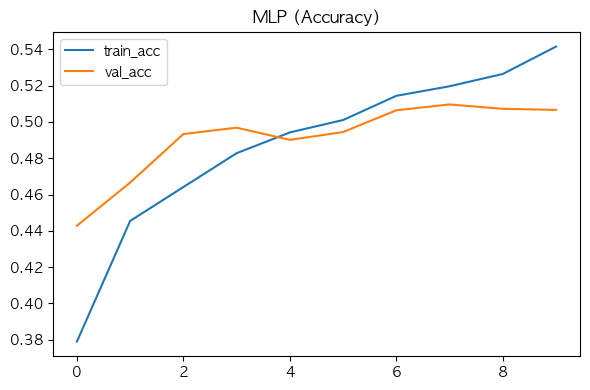

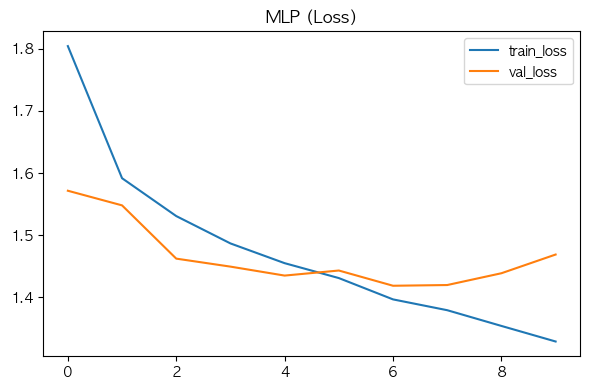

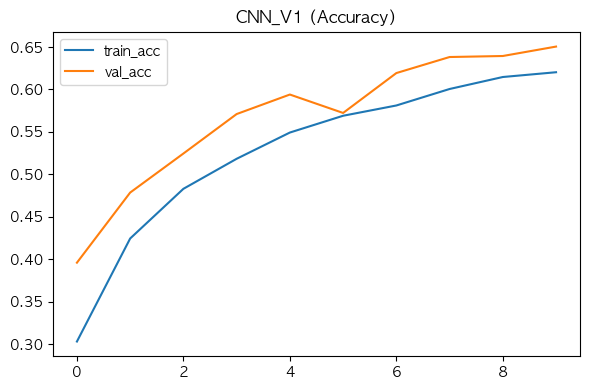

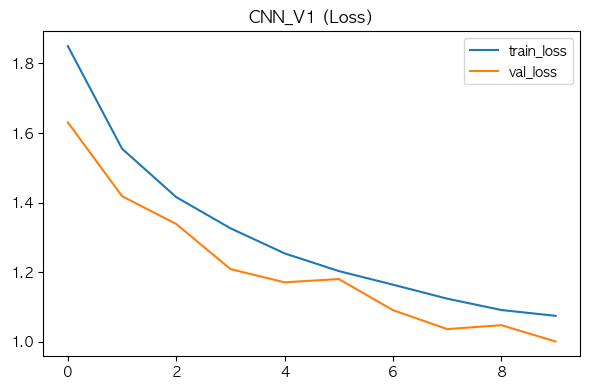

In [18]:
# -------------------------------
# 학습곡선(Accuracy, Loss)을 나란히 플롯하는 함수
# -------------------------------
def plot_hist(h, title):
    # 정확도 곡선
    plt.figure(figsize=(6,4))
    plt.plot(h['train_acc'], label='train_acc')  # 학습 정확도
    plt.plot(h['val_acc'], label='val_acc')      # 검증 정확도
    plt.title(title+'(Accuracy)')                # 제목 (모델 이름 + Accuracy)
    plt.legend(); plt.tight_layout(); plt.show()

    # 손실 곡선
    plt.figure(figsize=(6,4))
    plt.plot(h['train_loss'], label='train_loss')  # 학습 손실
    plt.plot(h['val_loss'], label='val_loss')      # 검증 손실
    plt.title(title+'(Loss)')                      # 제목 (모델 이름 + Loss)
    plt.legend(); plt.tight_layout(); plt.show()

# -------------------------------
# MLP 학습곡선 출력
# -------------------------------
plot_hist(mlp_hist, 'MLP ')

# -------------------------------
# CNN_V1 학습곡선 출력
# -------------------------------
plot_hist(cnn_hist, 'CNN_V1 ')


### 4. 오분류 분석

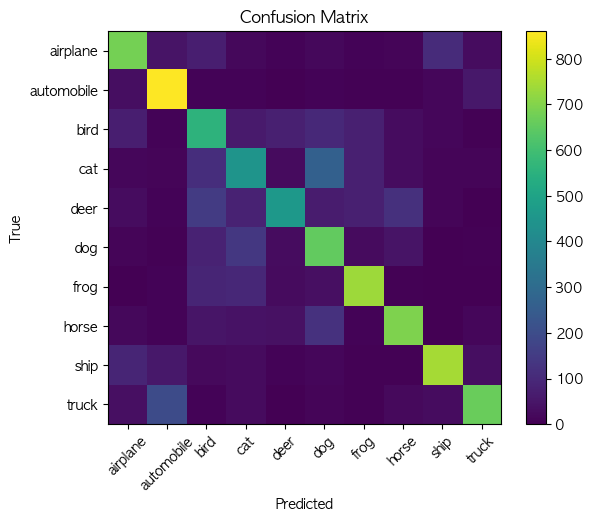

In [19]:
# -------------------------------
# 모델 예측값 전체 얻기 (테스트셋 등에서)
# -------------------------------
@torch.no_grad()   # 평가 시에는 gradient 계산 끔 → 메모리/속도 최적화
def get_all_preds(model, loader):
    model.eval()        # 평가 모드 (Dropout, BN 고정)
    ys=[]; ps=[]        # 정답 레이블(ys), 예측 레이블(ps) 저장용
    for x, y in loader:
        x = x.to(device)
        out = model(x)  # forward → logits
        ps.append(out.argmax(1).cpu().numpy())  # 예측 레이블
        ys.append(y.numpy())                    # 정답 레이블
    # 리스트들을 하나의 큰 배열로 합치기
    return np.concatenate(ys), np.concatenate(ps)

# 전체 테스트셋 예측값 얻기
y_true, y_pred = get_all_preds(cnn, test_loader)

# -------------------------------
# 혼동 행렬(confusion matrix) 계산 및 시각화
# -------------------------------
cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')  # 혼동행렬 heatmap
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(range(10), class_names, rotation=45)  # X축 = 예측 클래스
plt.yticks(range(10), class_names)               # Y축 = 실제 클래스
plt.tight_layout()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [20]:
# -------------------------------
# 가장 많이 혼동된 클래스 쌍 Top-3 추출
# -------------------------------
pairs = []
for i in range(10):
    for j in range(10):
        if i!=j and cm[i,j] > 0:       # i≠j: 정답과 예측이 다른 경우
            pairs.append(((i,j), cm[i,j]))   # ((실제, 예측), 횟수)

# 혼동 빈도 기준으로 내림차순 정렬 → 상위 3개
pairs = sorted(pairs, key=lambda x: x[1], reverse=True)[:3]
print('Top-3 혼동 클래스 쌍:', [(class_names[i], class_names[j], n) for (i,j), n in pairs])

# -------------------------------
# 혼동 사례 이미지 표시
# -------------------------------
# 원본 CIFAR-10 테스트셋 (정규화 안 된 형태로)
raw_test = datasets.CIFAR10(root='./data', train=False, download=False,
                            transform=transforms.ToTensor())

# test_loader와 raw_test 인덱스는 다를 수 있으므로, 직접 다시 예측해서 위치 확인
def find_mismatch_indices(true_label, pred_label, max_show=6):
    """
    true_label: 실제 라벨
    pred_label: 잘못 예측된 라벨
    max_show  : 최대 몇 장 보여줄지
    """
    out_idx = []
    count = 0
    ptr = 0  # 전체 데이터셋 인덱스 추적
    for batch_x, batch_y in DataLoader(test_set, batch_size=128, shuffle=False):
        with torch.no_grad():
            logits = cnn(batch_x.to(device))
            preds = logits.argmax(1).cpu().numpy()
        # 배치 내 샘플 확인
        for k in range(len(batch_y)):
            if batch_y[k].item()==true_label and preds[k]==pred_label:
                out_idx.append(ptr+k)   # 원본 데이터셋에서의 인덱스
                count += 1
                if count >= max_show:
                    return out_idx
        ptr += len(batch_y)
    return out_idx

Top-3 혼동 클래스 쌍: [('cat', 'dog', 265), ('truck', 'automobile', 197), ('deer', 'bird', 150)]


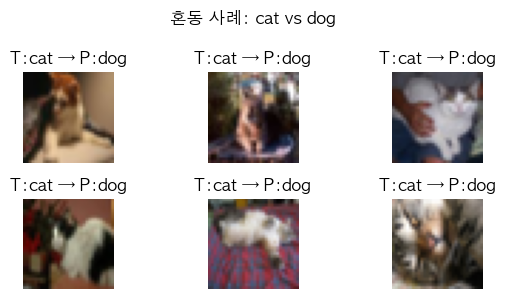

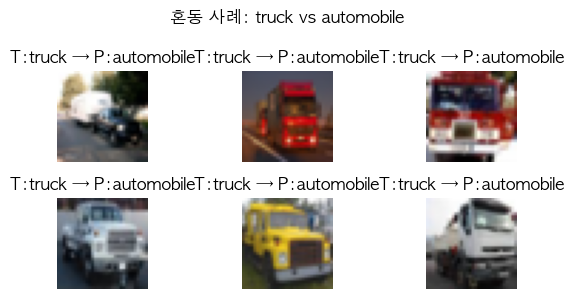

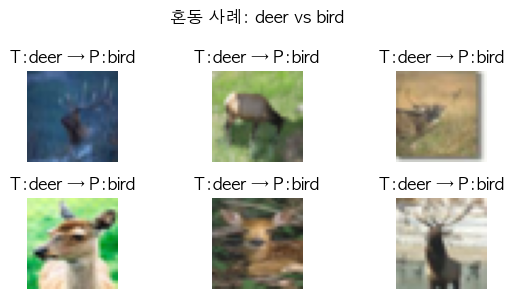

In [21]:


# -------------------------------
# Top-3 혼동 클래스 쌍별로 샘플 이미지 6장씩 시각화
# -------------------------------
for (i,j), _ in pairs:
    ids = find_mismatch_indices(i,j, max_show=6)
    if not ids: continue
    plt.figure(figsize=(6,3))
    for k, idx in enumerate(ids):
        img, _ = raw_test[idx]   # (C,H,W)
        plt.subplot(2,3,k+1)
        plt.imshow(img.permute(1,2,0))  # (H,W,C)로 변환 후 출력
        plt.axis('off')
        plt.title(f'T:{class_names[i]} → P:{class_names[j]}')  # 실제 vs 예측
    plt.suptitle(f'혼동 사례: {class_names[i]} vs {class_names[j]}')
    plt.tight_layout()
    plt.show()


#### 모델 개선 방안
- Data Augmentation(회전, 뒤집기 등): 일반화 성능 개선.
- Conv 블록마다 BatchNorm(학습 안정화/수렴 가속) & Dropout (과적합 방지).
- 학습(epoch) 횟수를 늘려보기.
- CNN_V1 대신 MobileNet, EfficientNet 같은 검증된 아키텍처 활용.


### 5. 성능 개선 기법


In [22]:
# ------------------------------------------------------------
# 데이터 증강(Augmentation) 파이프라인 + 정규화
#  - 좌우반전, 랜덤 크롭, 색상 변형으로 데이터 다양성 ↑ → 과적합 완화
#  - 마지막에 CIFAR-10 통계로 Normalize
# ------------------------------------------------------------
aug_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),                 # 50% 확률로 좌우 반전
    transforms.RandomCrop(32, padding=4),              # 가장자리에 4픽셀 패딩 후 32x32 무작위 크롭
    transforms.ColorJitter(brightness=0.2,             # 밝기/대비/채도 약간 변형
                           contrast=0.2,
                           saturation=0.2),
    transforms.ToTensor(),                             # [0,255] → [0,1] Tensor
    transforms.Normalize((0.4914,0.4822,0.4465),       # 채널별 평균/표준편차 (CIFAR-10)
                         (0.2470,0.2435,0.2616))
])

# 증강 적용한 학습 전체셋을 동일한 비율로 train/val 분할
train_full_aug = datasets.CIFAR10(root='./data', train=True, download=False, transform=aug_tf)
train_set2, val_set2 = random_split(train_full_aug, [train_len, val_len])

# DataLoader: 학습은 섞고(shuffle=True), 검증은 고정(shuffle=False)
train_loader2 = DataLoader(train_set2, batch_size=128, shuffle=True,  num_workers=0)
val_loader2   = DataLoader(val_set2,   batch_size=128, shuffle=False, num_workers=0)

In [23]:
# ------------------------------------------------------------
# 개선 모델: CNN_V2
#  - Conv 블록마다 BatchNorm → 학습 안정화/수렴 가속
#  - Dropout → 과적합 방지
#  - MaxPool로 해상도 축소, 마지막은 GAP(AdaptiveAvgPool2d(1,1))
# ------------------------------------------------------------
class CNN_V2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            # Block1: 32채널 두 번의 3x3 Conv + BN + ReLU
            nn.Conv2d(3, 32, 3, padding=1),  nn.BatchNorm2d(32),  nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32),  nn.ReLU(),
            nn.MaxPool2d(2),                  # 32→16로 다운샘플
            nn.Dropout(0.2),

            # Block2: 64채널 두 번의 3x3 Conv + BN + ReLU
            nn.Conv2d(32, 64, 3, padding=1),  nn.BatchNorm2d(64),  nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),  nn.BatchNorm2d(64),  nn.ReLU(),
            nn.MaxPool2d(2),                  # 16→8로 다운샘플
            nn.Dropout(0.3),

            # Block3: 128채널 Conv + BN + ReLU
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),

            # 분류 헤드: GAP → Flatten → Dropout → Linear
            nn.AdaptiveAvgPool2d((1,1)),      # (C, H, W) → (C, 1, 1) : Global Avg Pooling
            nn.Flatten(),                      # (N, 128, 1, 1) → (N, 128)
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)        # 최종 로지트
        )
    def forward(self, x):
        return self.net(x)

cnn2 = CNN_V2().to(device)

# 다중분류 손실
criterion = nn.CrossEntropyLoss()

[CNN_V2][SGD][Ep 1] train=0.334/1.758  val=0.461/1.463
[CNN_V2][SGD][Ep 2] train=0.473/1.431  val=0.503/1.354
[CNN_V2][SGD][Ep 3] train=0.528/1.301  val=0.557/1.253
[CNN_V2][SGD][Ep 4] train=0.562/1.210  val=0.554/1.252
[CNN_V2][SGD][Ep 5] train=0.582/1.156  val=0.631/1.032
[CNN_V2][SGD][Ep 6] train=0.608/1.101  val=0.603/1.087
[CNN_V2][SGD][Ep 7] train=0.621/1.063  val=0.651/0.974
[CNN_V2][SGD][Ep 8] train=0.634/1.025  val=0.665/0.945
[CNN_V2][SGD][Ep 9] train=0.645/0.996  val=0.608/1.105
[CNN_V2][SGD][Ep 10] train=0.655/0.973  val=0.688/0.884
[CNN_V2][SGD][Ep 11] train=0.663/0.940  val=0.704/0.834
[CNN_V2][SGD][Ep 12] train=0.673/0.922  val=0.700/0.848
[CNN_V2][SGD][Ep 13] train=0.681/0.901  val=0.677/0.897
[CNN_V2][SGD][Ep 14] train=0.692/0.880  val=0.703/0.849
[CNN_V2][SGD][Ep 15] train=0.695/0.869  val=0.731/0.773


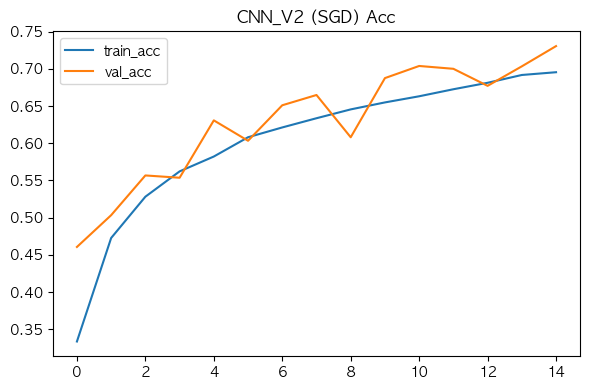

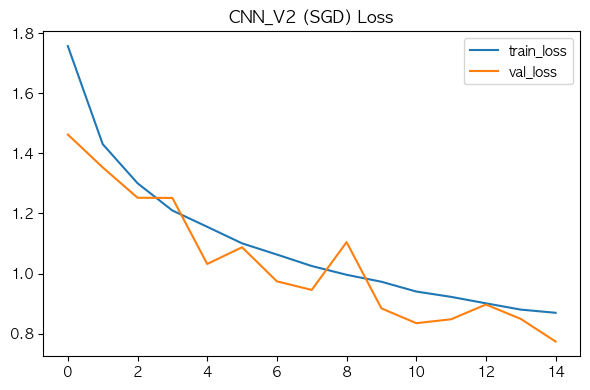

In [24]:


# ------------------------------------------------------------
# Optimizer 실험: SGD(momentum) vs Adam
#  - opt_name만 바꿔 두 방식 비교 가능
# ------------------------------------------------------------
opt_name  = 'SGD'  # 'Adam'으로 바꾸면 Adam으로 실험
optimizer = (optim.SGD(cnn2.parameters(), lr=0.01, momentum=0.9)
             if opt_name == 'SGD'
             else optim.Adam(cnn2.parameters(), lr=1e-3))

# ------------------------------------------------------------
# 학습 루프: train/val 손실·정확도 기록 및 출력
# ------------------------------------------------------------
hist2 = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
for ep in range(1, 16):  # 기본 15epoch; 필요시 더 늘려도 좋음(예: 30~50)
    tr_l, tr_a = train_epoch(cnn2, train_loader2, criterion, optimizer)  # 1 epoch 학습
    va_l, va_a = eval_epoch(cnn2,  val_loader2,  criterion)              # 1 epoch 검증

    hist2['train_loss'].append(tr_l); hist2['val_loss'].append(va_l)
    hist2['train_acc'].append(tr_a);  hist2['val_acc'].append(va_a)

    print(f'[CNN_V2][{opt_name}][Ep {ep}] train={tr_a:.3f}/{tr_l:.3f}  val={va_a:.3f}/{va_l:.3f}')

# ------------------------------------------------------------
# 학습 곡선(정확도/손실) 시각화
# ------------------------------------------------------------
def plot_hist(h, title):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(h['train_acc'], label='train_acc')
    plt.plot(h['val_acc'],   label='val_acc')
    plt.title(title+' Acc'); plt.legend(); plt.tight_layout(); plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(h['train_loss'], label='train_loss')
    plt.plot(h['val_loss'],   label='val_loss')
    plt.title(title+' Loss'); plt.legend(); plt.tight_layout(); plt.show()

plot_hist(hist2, f'CNN_V2 ({opt_name})')
